In [ ]:
import numpy as np
from importlib import reload
import fdc
import tqdm
fdc=reload(fdc)
import matplotlib.pyplot as plt

# Simple random process with coupled Oersten-Uhlembeck 

In [2]:
N = 83
x = np.random.randn(N, 1000) / np.sqrt(N)
np.shape(np.triu(x))

(83, 1000)

In [3]:
time_step = 1
frequency = 250
n_chunks = 1

In [4]:
s = fdc.correlation_freq(x,time_step,frequency)

In [5]:
np.shape(s) #matrixe di correlazione integrate

(83, 83)

In [6]:
np.mean(np.diag(s).real)

np.float64(1.4264426352603729e-05)

In [7]:
sii = []
for freq in np.linspace(1,50,1000):
    s = fdc.correlation_freq(x,time_step,freq)
    smean = np.mean(np.diag(s).real)
    #print(smean)
    sii.append(smean)
    

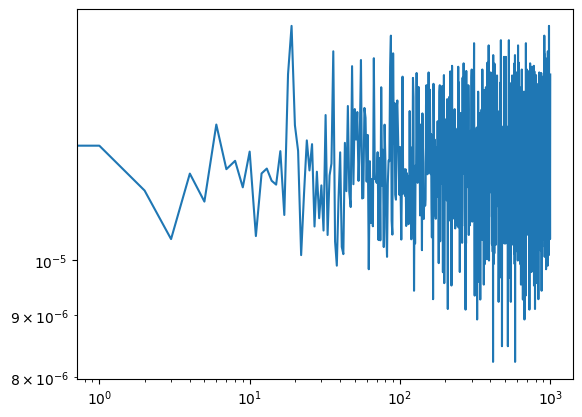

In [8]:
plt.plot(sii)
plt.xscale('log')
plt.yscale('log')


In [9]:
def generate_OU(J, T=20000, dt=1, sigma=1.0, g=None):
    """
    Generate multivariate Ornstein-Uhlenbeck (OU) process.
    
    Parameters
    ----------
    N : number of nodes
    T : number of time points
    dt : timestep in seconds
    g : global coupling (scales J)
    sigma : noise amplitude

    Returns
    -------
    X : array shape (N, T)
        OU time series ready to use with correlation_freq()
    """
    # Random Gaussian connectivity (consistent with the paper's theory)

    N = len(J)

    if g == None:
        lambdamax = np.max(np.linalg.eigvals(J))
        g = 1/lambdamax - 0.1
    
    X = np.zeros((N, T))
    noise_scale = np.sqrt(sigma * dt)

    for t in range(T-1):
        drift = (-X[:, t] + g * J @ X[:, t])
        noise = noise_scale * np.random.randn(N) 
        X[:, t+1] = X[:, t] + dt * drift + noise

    # Removing transient (optional)
    return X#[:, 5000:]   # discard first 5k samples


In [10]:
N = 83
A = np.random.randn(N, N) / np.sqrt(N)
J = (A + A.T) / 2

In [11]:
tp = 128
T = tp*30
dt=1/tp
x = generate_OU(J, T, dt, g=None)

In [12]:
N

83

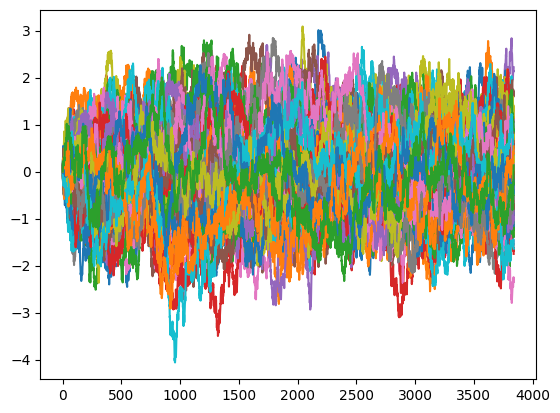

In [13]:
plt.plot(x.T);

In [14]:
np.shape(x)

(83, 3840)

In [15]:
x.shape = (N, T)   # Your OU data
dt  

0.0078125

In [16]:
freqs = np.linspace(0.0001, 100, 1000) #np.logspace(-3, 2., 50)  
omegas = 2 * np.pi * freqs

In [19]:
C_freq = np.zeros((N, N, len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(freqs):
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=10,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


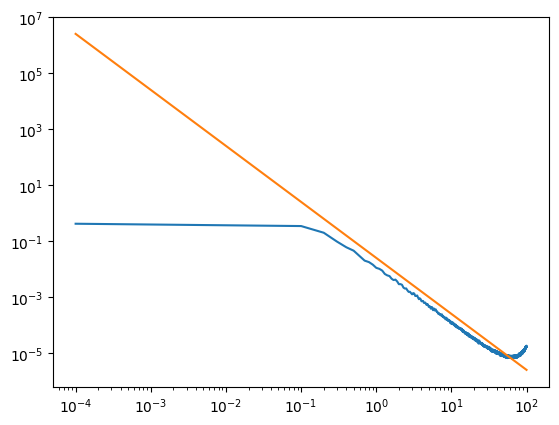

In [20]:
plt.loglog(freqs,S_ii)
plt.plot(freqs,1/omegas**2)
#plt.xlim(10e0,10)

# Block diagonal case 

In [111]:
N = 80

tp = 128
T = tp*30
dt=1/tp

freqs = np.linspace(1e-3, 100, 1000) #np.logspace(-3, 2., 50)  
omegas = 2 * np.pi * freqs


A = np.random.randn(int(N/2), int(N/2)) / np.sqrt(int(N/2))
J = (A + A.T) / 2
alpha = 1

if alpha < 1: 
    g = 1/(2*alpha) - 0.1
else:
    g = 1/(2*alpha) -0.3
beta = 100

omega_peak = beta/alpha

W = np.block([
        [ alpha * J,  -beta * J ],
        [ beta  * J,   alpha * J ]
    ])

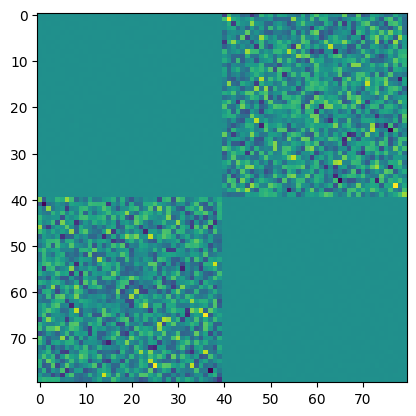

In [112]:
plt.imshow(W)

In [113]:
x = generate_OU(W, T, dt, g=g)

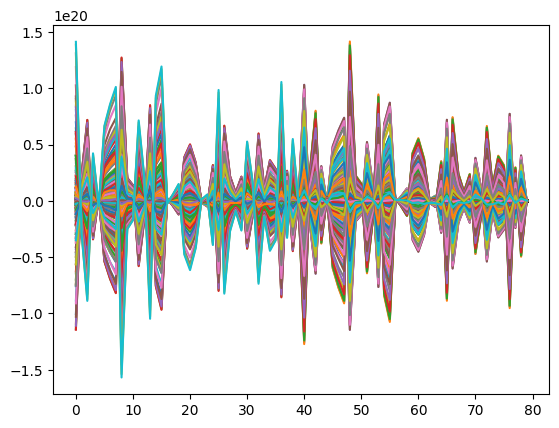

In [114]:
plt.plot(x)
plt.show()

In [115]:
x.shape = (x.shape[0], T)   # Your OU data
dt  

0.0078125

In [134]:
C_freq = np.zeros((x.shape[0], x.shape[0], len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(tqdm.tqdm(freqs, desc="Computing FDC", unit="freq")):
    #x= generate_OU(W, T, dt, g=g/np.sqrt(1+ (f)**2))
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=10,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))



Computing FDC: 100%|██████████| 1000/1000 [00:05<00:00, 175.20freq/s]


/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


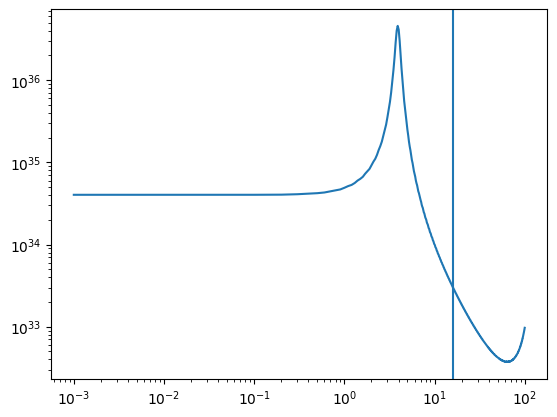

In [ ]:
plt.loglog(freqs,S_ii)
#plt.plot(freqs,1/omegas**2*10e12) 
plt.axvline(beta/(alpha))

In [146]:
np.argmax(S_ii)

np.int64(39)

In [147]:
freqs[np.argmax(S_ii)]

np.float64(3.904864864864865)

In [151]:
beta/(alpha)

100.0

In [154]:
g

0.2

In [150]:
2*g*beta/alpha

40.0